In [33]:
import os
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform
# import numpy as np
import cupy as cp
import shutil
from pathlib import Path
from random import random

plt.ion()

In [34]:
torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Setting up the Data
Understanding the file structure and the structuring of the given dataset by kaggle. 

In [35]:
BATCH_SIZE = 128
IMG_HEIGHT = 32
IMG_WIDTH = 32
RANDOM_SEED = 28

root = Path("data/cifar10")

# (root/'train').rename(root/'original_train')
# (root/'test').rename(root/'original_test')

In [36]:
image_dir = r"data/cifar10/original_train/train"
csv_path = r"data/cifar10/trainLabels.csv"

In [37]:
labels_df = pd.read_csv(csv_path)
print(labels_df.head())

label_to_int = {label: idx for idx, label in enumerate(labels_df['label'].unique())}
int_to_label = {idx: label for label, idx in label_to_int.items()}

print(label_to_int)
print(int_to_label)

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
{'frog': 0, 'truck': 1, 'deer': 2, 'automobile': 3, 'bird': 4, 'horse': 5, 'ship': 6, 'cat': 7, 'dog': 8, 'airplane': 9}
{0: 'frog', 1: 'truck', 2: 'deer', 3: 'automobile', 4: 'bird', 5: 'horse', 6: 'ship', 7: 'cat', 8: 'dog', 9: 'airplane'}


In [38]:
len(labels_df)

50000

In [39]:
random_seed = 42
torch.manual_seed(random_seed);

In [40]:
image_paths = labels_df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.png"))
labels = labels_df['label'].apply(lambda x: label_to_int[x])    # convert labels to int values according to label_to_int dict

In [41]:
print(image_paths.head())
print(labels.head())

0    data/cifar10/original_train/train\1.png
1    data/cifar10/original_train/train\2.png
2    data/cifar10/original_train/train\3.png
3    data/cifar10/original_train/train\4.png
4    data/cifar10/original_train/train\5.png
Name: id, dtype: object
0    0
1    1
2    1
3    2
4    3
Name: label, dtype: int64


## Setting up the Training and Pre-Processing

In [42]:
from PIL import Image

class Cifar10Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths.iloc[index])
        get_label = self.labels.iloc[index]
        
        if self.transform is not None:
            image = self.transform(image)

        if self.transform is None:
            image = ToTensor()(image)
            
        label_tensor = torch.tensor(get_label).type(torch.LongTensor)
        
        return image, label_tensor

```Python
# Data Loaeders for one fold


train_dataset = Cifar10Dataset(train_paths, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

mean = 0.0
std = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
```

This code helped me to find the mean and standard deviation of our Cifar10 Dataset, we shall put it in `transofrms.Normalize()` function. By this we can normalize the Tensors accordingly.



In [43]:
# mean /= len(train_loader.dataset)
# std /= len(train_loader.dataset)
# print(mean, std)

In [44]:
# Getting the image transformation on the training set
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=float(random_seed / 100)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.4914, 0.4822, 0.4465],
                         std= [0.2025, 0.1996, 0.2012]),
    transforms.RandomErasing(p=float(random_seed / 100), scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [45]:
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])


In [46]:
transformed_dataset = Cifar10Dataset(image_paths, labels, transform=train_transform)
# val_dataset = Cifar10Dataset(valid_paths, valid_labels, transform=valid_transform)
transformed_loader = DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [47]:
for x, y in transformed_dataset:
    print(x.device, y.device)
    print(x.shape, y.shape)
    print(y)
    break

cpu cpu
torch.Size([3, 32, 32]) torch.Size([])
tensor(0)


In [48]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(cp.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71333337..1.6006229].


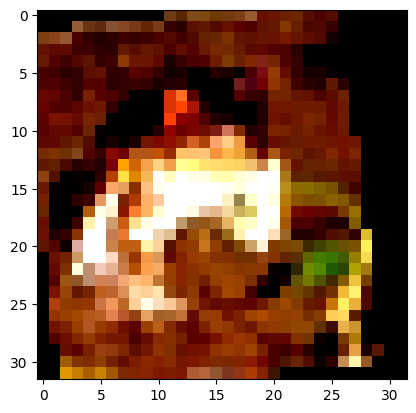

tensor(0)


In [49]:
for images, labels in transformed_dataset:
    img = images
    label = labels
    # print(torch.max(img), torch.min(img))
    imshow(img)
    print(label)
    break

## Defining the Model

We will be using a Convolutional Neural Network, with Batch Normalisation, `ReLU` activation function and `Max-Pooling` of 2 x 2 size


First we define a class for the model to refer to during the training of the model.

In [50]:
class Cifar10ModelBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        preds = self(images)  # Get Predictions
        loss = F.cross_entropy(preds, labels)
        return loss
    
    def valid_step(self, batch):
        images, labels = batch
        preds = self(images)
        loss = F.cross_entropy(preds, labels)
        acc = accuracy(preds, labels)           # Function to calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def valid_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accuracy.item()}
    
    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch+1}]: Loss of the Model = {result["val_loss"]:.4f}, Accuracy of the Model = {100 * result["val_acc"]:.2f} %')

    
def accuracy(outputs, label):
    _, preds = torch.max(outputs, dim= 1)   # Get the index of the max log-probability
    return torch.tensor(torch.sum(preds == label).item() / len(preds))

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [71]:
class Cifar10Model(Cifar10ModelBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            # CONV => BatchNORM => CONV => RELU => POOL => DROPOUT
            nn.Conv2d(3, 32, kernel_size= 3, padding= 1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size= 3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     # Output: 64 x 16 x 16
            nn.Dropout2d(0.2),

            # CONV => BatchNORM => CONV => RELU => POOL => DROPOUT
            nn.Conv2d(64, 128, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((256, 256)),     # Output: 128 x 8 x 8
            nn.Dropout2d(0.2),

            # CONV => BatchNORM => CONV => RELU => POOL => DROPOUT
            nn.Conv2d(256, 128, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size= 3, stride= 1, padding= 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),     # Output: 128 x 4 x 4
            nn.Dropout2d(0.2),

            nn.Flatten(),           # Flatten the output
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10),
        )

    def forward(self, xb):
        return self.network(xb)



Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image.

In [72]:
model = Cifar10Model().cuda()
# print(model)
summary(model, (3, 32, 32))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1048576 and 1024x512)

## Moving to GPU

We have made our model to run on the GPU, by calling the class object with a `.cuda()` parameter. Now we move our data to the GPU as-well

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataset, device, SAMPLER=None):
        self.dl = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=0, sampler=SAMPLER)
        self.device = device
        super().__init__(self)
        # self.batch = dataset
        
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    


In [22]:
transformed_loader_gpu = DeviceDataLoader(transformed_dataset, device)

## Training The Model!!

We define a `fit` and `evaluate` function to train the model using Stochastic Gradient Descent and evaluate its perfromance based on the validaton data.

In [23]:
def evaluate(model, val_loader):
    with torch.no_grad():
        outputs = [model.valid_step(batch) for batch in val_loader]
        return model.valid_epoch_end(outputs)
    
def fit(epochs, model, train_loader, valid_loader, lr=0.01, opt_func= torch.optim.SGD, getScheduler=None):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation
        result = evaluate(model, valid_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        if getScheduler is not None:
            val_loss = sum(result['val_loss']) / len(valid_loader)
            getScheduler.step(val_loss)
    return history

In [24]:
next(model.parameters()).is_cuda    # Check if the model is on the GPU

True

Before we begin with training, let's first evaluate the model before training

In [25]:
for images, labels in transformed_loader_gpu:
    print('images.shape:', images.shape)
    out = model(images)
    print(images.device, labels.device)
    print('out.shape:', out.shape)
    print(f'Labels shape: {labels.shape}')
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
Labels shape: torch.Size([128])


In [ ]:
evaluate(model, transformed_loader_gpu)

{'val_loss': 2.3084659576416016, 'val_acc': 0.09522458165884018}

## Learning Rate Scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

C:\Users\Arnav Waghdhare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Cross Validation
Setting up K-Fold Cross Validation from sklearn library

In [28]:
k = 5
kf = KFold(n_splits=k, random_state=random_seed, shuffle=True)

## Splitting the Data

* Using the folds to create train and valid splits
* Map ID's to image paths 

## K Fold Cross Validation 

Let's apply K-Fold cross validation on our testing dataset. We will divide the *50,000* images in to *5 folds*, so each fold will have *10,000* images.

In [29]:
k_folds_history = []
best_accuracy = 0.0

# Stratified K-Fold Cross Validation
for fold, (train_idx, valid_idx) in enumerate(kf.split(transformed_dataset)):
    print(f"Fold {fold+1}/{k}")
    print("------------------")

    num_epochs = 25

    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_idx)
    valid_subsampler = SubsetRandomSampler(valid_idx)

    # Define data loaders for training and testing data in this fold
    train_loader = DeviceDataLoader(transformed_dataset, device, train_subsampler)
    valid_loader = DeviceDataLoader(transformed_dataset, device, valid_subsampler)

    history = fit(num_epochs, model, train_loader, valid_loader, lr=lr, opt_func=torch.optim.AdamW)

    k_folds_history.append(history)
    print("------------------")
    min_val_loss = min(entry['val_loss'] for entry in history)
    max_val_acc = max(entry['val_acc'] for entry in history)
    print(f'Minimum Validation Loss: {min_val_loss}')
    print(f'Highest Accuracy: {max_val_acc}')
    if max_val_acc > best_accuracy:
            best_accuracy = max_val_acc
            model_save_path = f"model_fold_{fold+1}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model for fold {fold+1} saved with accuracy: {best_accuracy:.2f}%")

    print("------------------")

Fold 1/5
------------------
Epoch [1]: Loss of the Model = 1.6606, Accuracy of the Model = 38.97 %
Epoch [2]: Loss of the Model = 1.5146, Accuracy of the Model = 45.48 %
Epoch [3]: Loss of the Model = 1.3743, Accuracy of the Model = 50.62 %
Epoch [4]: Loss of the Model = 1.3013, Accuracy of the Model = 53.47 %
Epoch [5]: Loss of the Model = 1.2302, Accuracy of the Model = 56.28 %
Epoch [6]: Loss of the Model = 1.2197, Accuracy of the Model = 56.01 %
Epoch [7]: Loss of the Model = 1.1931, Accuracy of the Model = 58.13 %
Epoch [8]: Loss of the Model = 1.1245, Accuracy of the Model = 60.45 %
Epoch [9]: Loss of the Model = 1.1172, Accuracy of the Model = 60.72 %
Epoch [10]: Loss of the Model = 1.0889, Accuracy of the Model = 61.38 %
Epoch [11]: Loss of the Model = 1.0704, Accuracy of the Model = 62.61 %
Epoch [12]: Loss of the Model = 1.0458, Accuracy of the Model = 63.94 %
Epoch [13]: Loss of the Model = 1.0370, Accuracy of the Model = 63.73 %
Epoch [14]: Loss of the Model = 1.0297, Accur

KeyboardInterrupt: 

## Saving the Model
Am going to trianthis over night, so once the process is completed I need to save the model else I would have to spend another hour or so next time to get the fuckin model and run the stuff on it

In [ ]:
# Define the file path where the model will be saved
model_save_path = "Cifar10Trained_Lv2.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


In [ ]:
model.load_state_dict(torch.load("Cifar10Trained.pth"))
model = model.to(device)

In [31]:
test_images_dir = r"data/cifar10/original_test"
parent_list = sorted(os.listdir(test_images_dir), key=len)

# print(parent_list[:10])

In [ ]:
with open('data/cifar10/Submission_Lv2.csv', 'w') as file:
    file.write("id,label\n")
    for img_path in parent_list:
        # print(img_path[1])
        image = os.path.join(test_images_dir, img_path)
        image = Image.open(image)
        image = valid_transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)

        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted = int_to_label[predicted.item()]
        # print("Prediction Completed!")

        num = int(img_path.split('.')[0])
        file.write(f"{num},{predicted}\n")
        
        if num % 10000 == 0:
            print(f"Batch {num // 10000} done")
        if num == 300000:
            print("Finished!!!")
            